Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 129, 100, 1)
conv1 		 (?, 129, 100, 16)
deconv	 (?, ?, ?, 1)
Model consits of  12817 trainable parameters.
[[ 0.64462459  0.52467865  0.6994642  ...,  0.70415634  0.61691594
   0.70109767]
 [ 0.53524148  0.56748819  0.39094731 ...,  0.72671705  0.74036235
   0.71023893]
 [ 0.55474311  0.60216874  0.48746875 ...,  0.78354234  0.66514206
   0.7085129 ]
 ..., 
 [ 0.84375423  0.67871201  0.6509608  ...,  0.51205093  0.59618652
   0.74671298]
 [ 0.70008469  0.76900887  0.69512939 ...,  0.50023192  0.63571858
   0.5130415 ]
 [ 0.75091058  0.78764355  0.80160707 ...,  0.61391014  0.45447338
   0.66640419]]


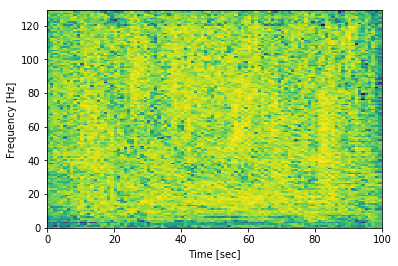

Forward pass successful!
Begin training loop
Epoch 1 : Train Loss 34743376.000, Valid loss 19629146.000
Epoch 2 : Train Loss 28466872.000, Valid loss 21809204.000
Epoch 3 : Train Loss 28466874.000, Valid loss 19957382.000
Epoch 4 : Train Loss 26610256.000, Valid loss 20483422.000
Epoch 5 : Train Loss 16656250.000, Valid loss 22090726.000
Epoch 6 : Train Loss 20833224.000, Valid loss 18876118.000
Epoch 7 : Train Loss 182831216.000, Valid loss 24646470.000
Epoch 8 : Train Loss 26587796.000, Valid loss 16602333.000
Epoch 9 : Train Loss 26101088.000, Valid loss 20139028.000
Epoch 10 : Train Loss 34743380.000, Valid loss 21071900.000
[[ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  1. ...,  1.  1.  1.]
 [ 0.  1.  1. ...,  1.  1.  0.]
 ..., 
 [ 0.  0.  1. ...,  1.  1.  1.]
 [ 1.  1.  0. ...,  1.  1.  1.]
 [ 1.  0.  0. ...,  1.  1.  1.]]


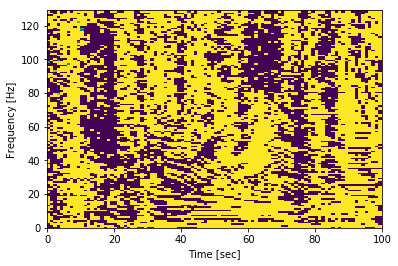

(<matplotlib.text.Text at 0x7f0d6a7b9c50>,
 (0.75, 1.03))

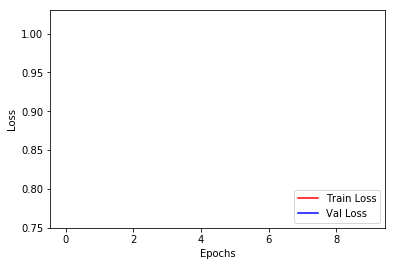

In [7]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import utils
from librispeech_mixer import LibriSpeechMixer
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose


tf.reset_default_graph()

height, width, nchannels = 129, 100, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (20,20)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, height, width, nchannels], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='sigmoid')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    """pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())"""



with tf.variable_scope('output_layer'):
    deconv = Conv2DTranspose(1, kernel_size_1, strides=(1,1), padding=padding, activation='sigmoid')

    y = deconv(x)
    print('deconv\t', y.get_shape())

print('Model consits of ', utils.num_params(), 'trainable parameters.')

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

"""## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)"""


with tf.variable_scope('loss'):
    # computing cross entropy per sample
    mean_square_error = tf.reduce_mean(abs(y_pl - y))



with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

    # applying the gradients
    train_op = optimizer.minimize(mean_square_error)


#Create the LibriSpeech mixer
mixer = LibriSpeechMixer()
width = mixer.spec_length
validation_mixer = LibriSpeechMixer(False)

#Test the forward pass
x_batch, y_batch = mixer.get_batch(2)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    
    plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]+1e-10))
    print(y_pred[0,:,:,0])
    plt.axis('tight')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
assert y_pred.shape == x_batch.shape, "ERROR the output shape is not as expected!"         + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


# ## Training

#Training Loop
batch_size = 2
max_epochs = 10


valid_loss = []
train_loss = []
test_loss = []
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

def trainingLoog():
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:

            while mixer.epochs_completed < max_epochs:
                _train_loss = []

                ## Run train op
                x_batch, y_batch = mixer.get_batch(batch_size)
                fetches_train = [train_op, mean_square_error]
                feed_dict_train = {x_pl: x_batch, y_pl: x_batch}
                _, _loss = sess.run(fetches_train, feed_dict_train)

                _train_loss.append(_loss)

                ## Compute validation loss
                if mixer.index_in_epoch <= batch_size:
                    _valid_loss = []
                    train_loss.append(np.mean(_train_loss))

                    fetches_valid = [mean_square_error]

                    while validation_mixer.epochs_completed <= mixer.epochs_completed:
                        x_valid, y_valid = validation_mixer.get_batch(batch_size)
                        feed_dict_valid = {x_pl: x_valid, y_pl: x_valid}
                        _loss = sess.run(fetches_valid, feed_dict_valid)

                        _valid_loss.append(_loss)

                    valid_loss.append(np.mean(_valid_loss))


                    print("Epoch {} : Train Loss {:6.3f}, Valid loss {:6.3f}".format(
                        mixer.epochs_completed, train_loss[-1], valid_loss[-1]))

        
        except KeyboardInterrupt:
            pass
        
        y_pred = sess.run(fetches=x, feed_dict={x_pl: x_batch})
    
        plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]+1e-10))
        print(y_pred[0,:,:,0])
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
trainingLoog();


    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss,'r', epoch, valid_loss,'b')
plt.legend(['Train Loss','Val Loss'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0.75,1.03])